In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tea357siddhimalave","key":"462531d48efdc976f53dc6019e758ef1"}'}

In [4]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

 99% 2.68G/2.70G [01:21<00:00, 29.4MB/s]
100% 2.70G/2.70G [01:21<00:00, 35.5MB/s]


In [9]:
!ls

kaggle.json  new-plant-diseases-dataset.zip  sample_data


In [10]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras

from keras.preprocessing.image import ImageDataGenerator, img_to_array,load_img
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [12]:
train_datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip = True,preprocessing_function=preprocess_input)
val_datagen =ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train = train_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",target_size =(256,256),batch_size=32)

val = val_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",target_size =(256,256),batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [14]:
t_img,label =train.next()

In [15]:
t_img.shape

(32, 256, 256, 3)

In [16]:
def plotImage(img_arr,label):
  for im,l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.imshow(im/255)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


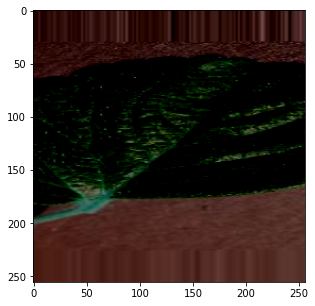

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


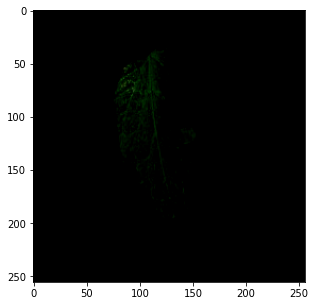

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


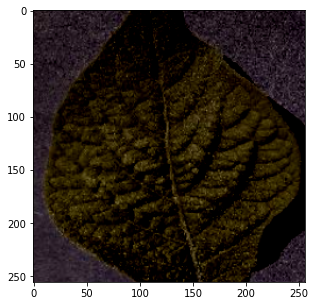

In [17]:
plotImage(t_img[:3],label[:3])

Building Model

In [18]:
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras



In [19]:
base_model = VGG19(input_shape=(256,256,3),include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [20]:
for layer in base_model.layers:
  layer.trainable =False

In [21]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
X = Flatten()(base_model.output)
X =Dense(units=38,activation='softmax')(X)
#creating our model
model = Model(base_model.input,X)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [24]:
model.compile(optimizer='adam',loss = keras.losses.categorical_crossentropy,metrics = ['accuracy'])

Early Stoping and Model Check point

In [26]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#early stopping
es = EarlyStopping(monitor ='val_accuracy',min_delta=0.01,patience=3,verbose=1)
#model cgeck point 
mc = ModelCheckpoint(filepath="best_model.h5",monitor ='val_accuracy',
                     min_delta=0.01,patience=3,verbase=1,
                     save_best_only=True)


cb = [es,mc]

In [29]:
his = model.fit_generator(train,
                          steps_per_epoch=16,
                          epochs = 50,
                          verbose =1,
                          callbacks= cb,
                          validation_data=val,
                          validation_steps=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 11.2456 - accuracy: 0.6523 - val_loss: 7.4024 - val_accuracy: 0.7422
Epoch 2/50
16/16 [==============================] - 21s 1s/step - loss: 8.9066 - accuracy: 0.6973 - val_loss: 6.6075 - val_accuracy: 0.7578
Epoch 3/50
16/16 [==============================] - 19s 1s/step - loss: 8.2640 - accuracy: 0.7188 - val_loss: 5.0068 - val_accuracy: 0.8105
Epoch 4/50
16/16 [==============================] - 18s 1s/step - loss: 9.2632 - accuracy: 0.6992 - val_loss: 5.7299 - val_accuracy: 0.7715
Epoch 5/50
16/16 [==============================] - 18s 1s/step - loss: 6.6711 - accuracy: 0.7383 - val_loss: 6.5045 - val_accuracy: 0.8125
Epoch 6/50
16/16 [==============================] - 20s 1s/step - loss: 6.7223 - accuracy: 0.7422 - val_loss: 4.2268 - val_accuracy: 0.8340
Epoch 7/50
16/16 [==============================] - 19s 1s/step - loss: 7.2105 - accuracy: 0.7617 - val_loss: 5.5469 - val_accuracy: 0.7988
Epoch 8/50
16/16 [=

In [31]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

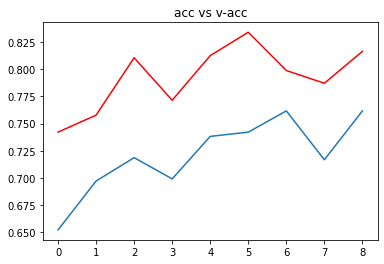

In [32]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title("acc vs v-acc")
plt.show()

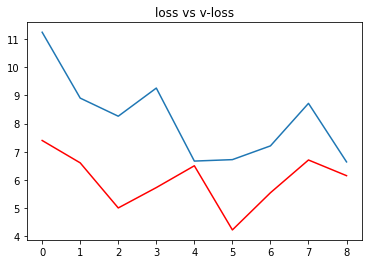

In [33]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")
plt.title("loss vs v-loss")
plt.show()

In [34]:
#load best model
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [35]:
acc = model.evaluate_generator(val)[1]
print(f"The accuracy of your model is {acc*100}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The accuracy of your model is 81.49897456169128%


In [54]:
ref= dict(zip(list(train.class_indices.values()),train.class_indices.keys()))

In [57]:
def predict(path):
  img = load_img(path,target_size=(256,256))
  i=img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im,axis =0)
  pred = np.argmax(model.predict(img))
  print(f"the image belongs to {ref[pred]}")

In [59]:
path = "/content/test/test/TomatoEarlyBlight1.JPG"
predict(path)

the image belongs to Tomato___Septoria_leaf_spot
